In [1]:
import random
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


In [2]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

if torch.cuda.is_available(): device = torch.device("cuda")
elif torch.backends.mps.is_available(): device = torch.device("mps")
else: device = torch.device('cpu')
# device = torch.device('cpu')

In [3]:
# input_window, output_window, batch_size, epochs, feature_size, d_ff, num_layers, lr, dropout
params = [120, 1, 32, 300, 32, 512, 2, 1e-5, 0.1]

In [4]:
DATA_TYPE = "PMJ_"

In [5]:
# type_120-120_32_128-256-2_0.0005_200_0.1 #

In [17]:
if DATA_TYPE == 'PMJ_':
    from transformer_type.model import TransAm
    from transformer_type.dataset import get_data

    DATA_PATH = "./data/kaggle_data/daily_data/"
    # type_120-60_32_32-512-2_1e-05_100_0.1
    MODEL_PATH = r"C:\Users\qja19\Desktop\탄소\machine_learning\transformer_results\type_120-60_32_32-512-2_1e-05_100_0.1\models"

    def data_extract(df_dict, df, name, cols):
        for col in cols:
                df_dict[f"{name}_{col}"] = df.loc[df[col] != 0, col]
        return df_dict

    train_data_list = []
    val_data_list = []

    pmj_df = pd.read_csv(DATA_PATH + "pjm_elec_daily.csv")
    pmj_cols = ['AEP', 'COMED', 'DAYTON', 'DOM', 'DUQ', 'FE', 'NI', 'PJME', 'PJMW'] # 'DEOK',
    # pmj_cols = ['AEP']

    df_dict = {}

    df_dict = data_extract(df_dict, pmj_df, 'PMJ', pmj_cols)

    for df_name in df_dict:
        df = df_dict[df_name]
        train_data, val_data, scaler = get_data(df, params[0], params[1])
        train_data = train_data.to(device)
        val_data = val_data.to(device)
        print(df_name, len(df), len(train_data), len(val_data), len(val_data)-60)
        train_data_list.append((train_data, df_name, scaler))
        val_data_list.append((val_data, df_name, scaler))

else:
    from transformer_multistep import TransAm, get_data

    DATA_PATH = "./data/korea/kor_gas_day.csv"
    MODEL_PATH = r"C:\Users\qja19\Desktop\탄소\machine_learning\transformer_results\single_model\120-1_64_32-2_1e-05_100\120_64_32-2_1e-05_100.pt"
    type_list = ['A', 'B', 'C', 'D', 'E', 'G', 'H']

    train_data1, val_data1, scaler1 = get_data('A')
    train_data2, val_data2, scaler2 = get_data('B')
    train_data3, val_data3, scaler3 = get_data('C')
    train_data4, val_data4, scaler4 = get_data('D')
    train_data5, val_data5, scaler5 = get_data('E')
    train_data6, val_data6, scaler6 = get_data('G')
    train_data7, val_data7, scaler7 = get_data('H')

    train_data_list = ((train_data1, 'A', scaler1),
                    (train_data2, 'B', scaler2),
                    (train_data3, 'C', scaler3),
                    (train_data4, 'D', scaler4),
                    (train_data5, 'E', scaler5),
                    (train_data6, 'G', scaler6),
                    (train_data7, 'H', scaler7)
                    )

    val_data_list = ((val_data1, 'A', scaler1),
                    (val_data2, 'B', scaler2),
                    (val_data3, 'C', scaler3),
                    (val_data4, 'D', scaler4),
                    (val_data5, 'E', scaler5),
                    (val_data6, 'G', scaler6),
                    (val_data7, 'H', scaler7)
                    )

PMJ_AEP 5055 3923 890 830
PMJ_COMED 2772 2096 434 374
PMJ_DAYTON 5055 3923 890 830
PMJ_DOM 4843 3753 848 788
PMJ_DUQ 4963 3849 872 812
PMJ_FE 2621 1975 404 344
PMJ_NI 2437 1828 367 307
PMJ_PJME 6059 4726 1091 1031
PMJ_PJMW 5969 4654 1073 1013


In [18]:
def inverse_scaling(value):
    return float(scaler.inverse_transform(value.cpu().detach().reshape(1, -1)))

In [25]:
pred_seq = 60
if DATA_TYPE == 'PMJ_':
    models = {'PMJ_' + t : TransAm(32, 2, 512, 0.1) for t in pmj_cols}
    for t in pmj_cols:
        models['PMJ_' + t].load_state_dict(torch.load(MODEL_PATH + f"\\PMJ_{t}.pt"))
        models['PMJ_' + t].to(device)
else:
    model = TransAm(32, 2, 0.1)
    model.load_state_dict(torch.load(MODEL_PATH))
    model.to(device)
cur_values = {}
predictions = {}
true_values = {}
input_window, output_window = params[:2]

predictions_period = {}
true_values_period = {}
cur_values_period = {}

for val_data, t, scaler in val_data_list:
    if DATA_TYPE == 'PMJ_':
        model = models[t]
    model.eval()
    cur_values[t] = []
    predictions[t] = []
    true_values[t] = []

    predictions_period[t] = []
    true_values_period[t] = []
    cur_values_period[t] = []

    for i in tqdm(range(len(val_data) - pred_seq)):
        data = val_data[i][0][:-1].reshape(-1, 1, 1)
        data.to(device)
        cur_values[t].append(float(scaler.inverse_transform(val_data[i][1][-1].cpu().detach().reshape(1, -1))))
        cur_values_period[t].append([float(scaler.inverse_transform(val_data[i][1][-1].cpu().detach().reshape(1, -1)))] * pred_seq)
        for _ in range(pred_seq):
            input = torch.clone(data[-input_window:])
            input[-output_window:] = 0     
            output = model(data[-input_window:])
            data = torch.cat((data[:-1], output[-1:], torch.Tensor([[[.0]]]).to(device)))
        predictions[t].append(float(scaler.inverse_transform(output[-1:].cpu().detach().reshape(1, -1))))
        true_values[t].append(float(scaler.inverse_transform(val_data[i + pred_seq][1][-1].cpu().detach().reshape(1, -1))))

        predictions_period[t].append([inverse_scaling(d) for d in list(data[-pred_seq-1:-1])])
        true_values_period[t].append([inverse_scaling(d) for d in list(val_data[i + pred_seq][1][-pred_seq-1:-1])])

100%|██████████| 1013/1013 [02:22<00:00,  7.09it/s]


AEP 830
rmse:2896435456.0, mape:0.1187121793627739, smape:0.1175910085439682, r2:-0.5478684902191162 (cur)
rmse:1527763584.0, mape:0.09048910439014435, smape:0.08875670284032822, r2:0.1824798583984375 (pred)
COMED 374
rmse:2316567808.0, mape:0.13226301968097687, smape:0.1314847469329834, r2:-0.6461077332496643 (cur)
rmse:1399651456.0, mape:0.09678535908460617, smape:0.10001210868358612, r2:-0.002963630249723792 (pred)
DAYTON 830
rmse:71942104.0, mape:0.13959422707557678, smape:0.13792401552200317, r2:-0.592206597328186 (cur)
rmse:44488628.0, mape:0.11697565764188766, smape:0.11318109184503555, r2:0.01397194154560566 (pred)
DOM 788
rmse:3076473344.0, mape:0.15523962676525116, smape:0.1533498764038086, r2:-0.5569858551025391 (cur)
rmse:1658459776.0, mape:0.10725586861371994, smape:0.11146626621484756, r2:0.16201424598693848 (pred)
DUQ 812
rmse:38034392.0, mape:0.12092942744493484, smape:0.12043914198875427, r2:-0.3501121401786804 (cur)
rmse:29941262.0, mape:0.13055483996868134, smape:0.1

<Figure size 1000x1000 with 0 Axes>

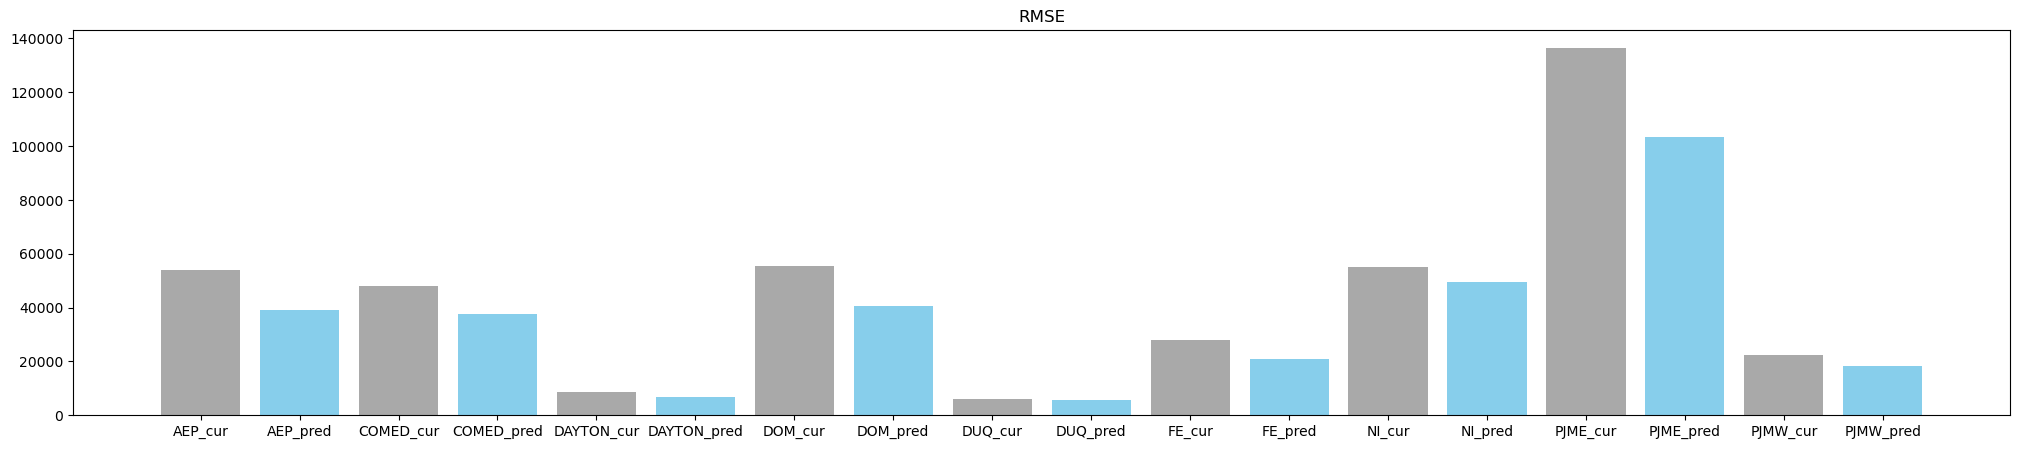

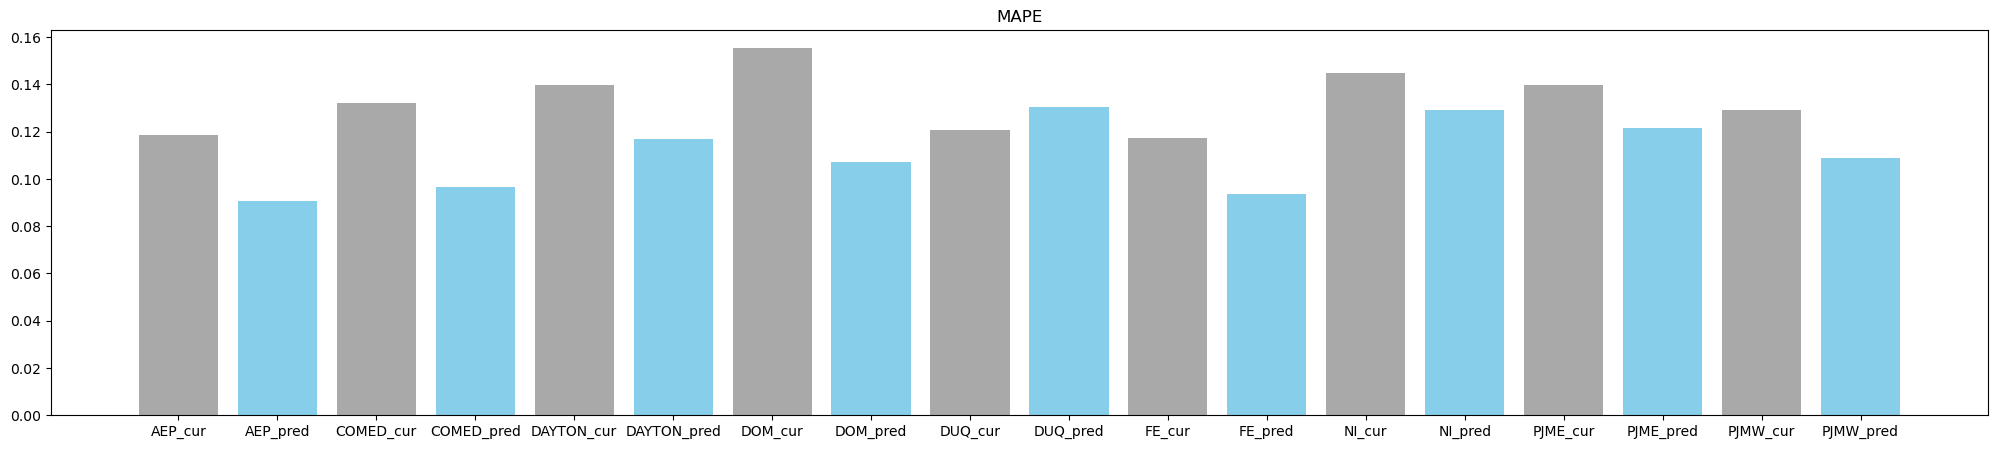

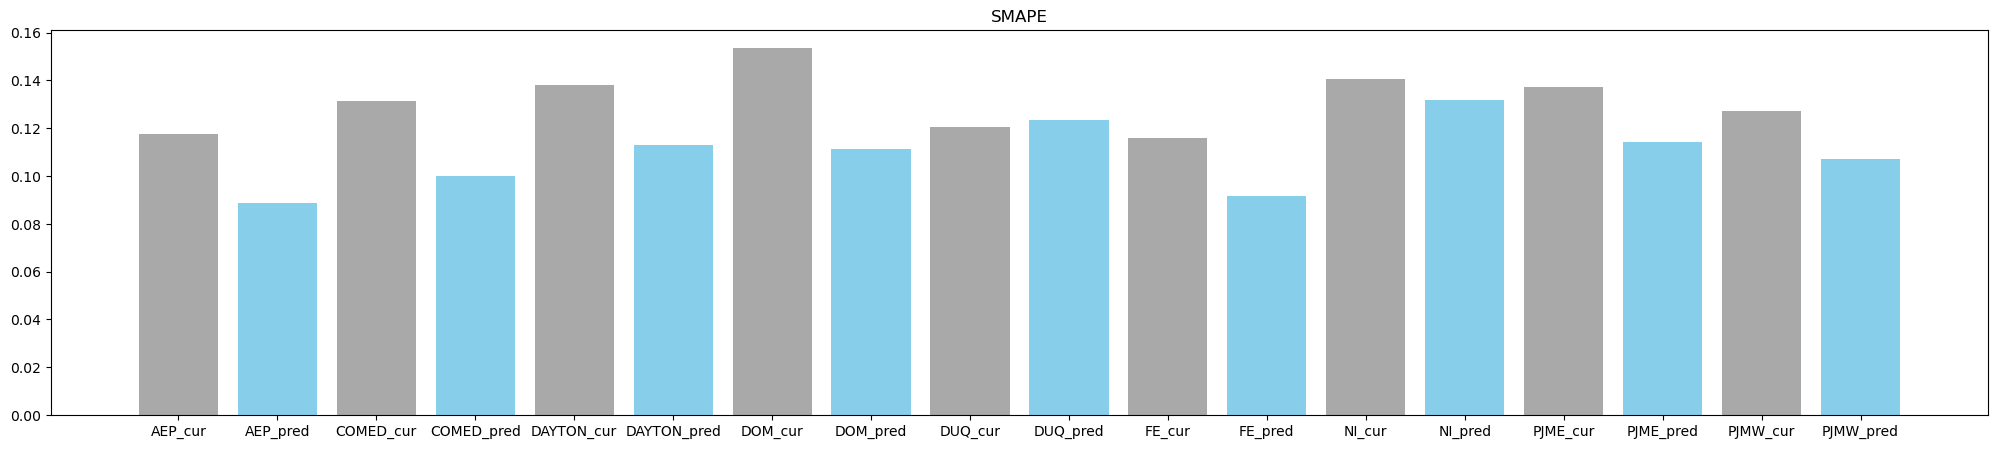

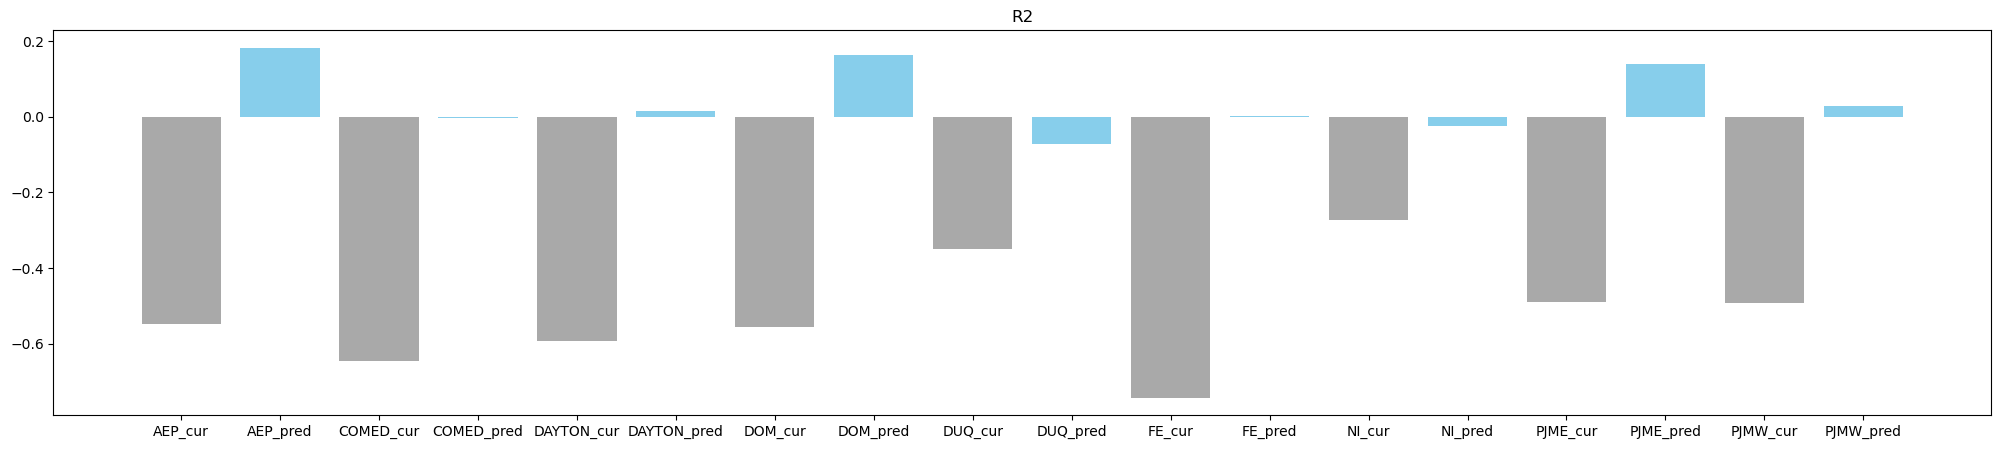

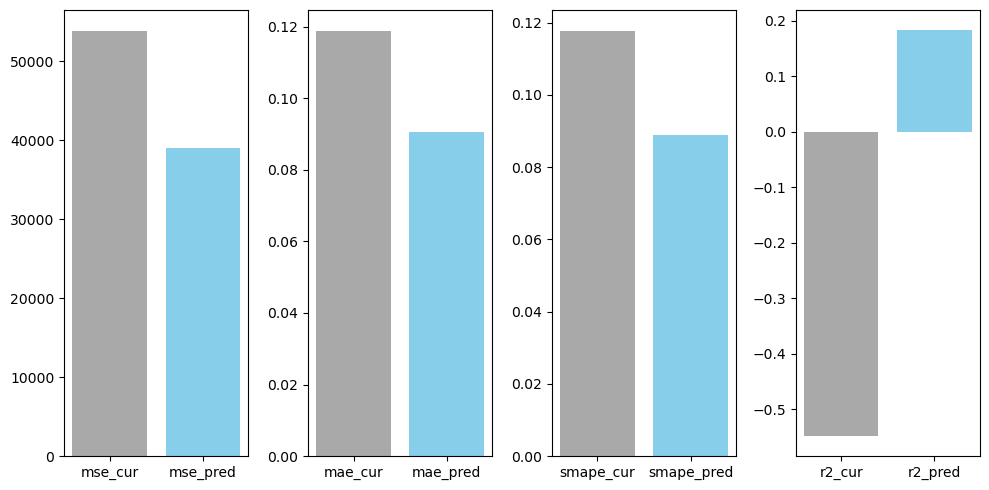

rmse : 53818.54296875 / 39086.6171875, mae : 0.1187121793627739 / 0.09048911184072495, smape : 0.1175910010933876 / 0.08875670284032822, r2 : -0.5478684306144714 / 0.1824798434972763


In [26]:
import torch.nn as nn
from torchmetrics.regression import SymmetricMeanAbsolutePercentageError as SMAPE, MeanAbsolutePercentageError as MAPE, R2Score as R2
# from torchmetrics import 

is_period = True

mse = nn.MSELoss()
mape = MAPE()
smape = SMAPE()
r2 = R2(pred_seq)

tot_len = 0

tot_mse_cur = 0
tot_mape_cur = 0
tot_smape_cur = 0
tot_r2_cur = 0

tot_mse_pred = 0
tot_mape_pred = 0
tot_smape_pred = 0
tot_r2_pred = 0

mse_score = []
mape_score = []
smape_score = []
r2_score = []

plot_col = 3

plt.figure(figsize=(10, 10))

for t in pmj_cols:
    if DATA_TYPE == 'PMJ_':
        cur, pred, true = torch.Tensor(cur_values_period['PMJ_' + t]), torch.Tensor(predictions_period['PMJ_' + t]), torch.Tensor(true_values_period['PMJ_' + t])

    else:
        cur, pred, true = torch.Tensor(cur_values_period[t]), torch.Tensor(predictions_period[t]), torch.Tensor(true_values_period[t])
    print(t, len(true))
    mse_score += [mse(cur, true) ** 0.5, mse(pred, true) ** 0.5]
    mape_score += [mape(cur, true), mape(pred, true)]
    smape_score += [smape(cur, true), smape(pred, true)]

    r2_c, r2_p = 0, 0
    # for c, p, tr in zip(cur, pred, true):
    #     r2_c += r2(c, tr)
    #     r2_p += r2(p, tr)
    # r2_score += [r2_c, r2_p]

    r2_score += [r2(cur, true), r2(pred, true)]
    print(f"rmse:{mse(cur, true)}, mape:{mape(cur, true)}, smape:{smape(cur, true)}, r2:{r2_score[-2]} (cur)")
    print(f"rmse:{mse(pred, true)}, mape:{mape(pred, true)}, smape:{smape(pred, true)}, r2:{r2_score[-1]} (pred)")

    tot_mse_cur += mse_score[0] * len(true)
    tot_mape_cur += mape_score[0] * len(true)
    tot_smape_cur += smape_score[0] * len(true)
    tot_r2_cur += r2_score[0] * len(true)

    tot_mse_pred += mse_score[1] * len(true)
    tot_mape_pred += mape_score[1] * len(true)
    tot_smape_pred += smape_score[1] * len(true)
    tot_r2_pred += r2_score[1] * len(true)
    
    tot_len +=  len(true)


colors = ['darkgray', 'skyblue']

tot_mse_cur /= tot_len
tot_mape_cur /= tot_len
tot_smape_cur /= tot_len
tot_r2_cur /= tot_len

tot_mse_pred /= tot_len
tot_mape_pred /= tot_len
tot_smape_pred /= tot_len
tot_r2_pred /= tot_len


x_labels = []
for t in pmj_cols:
    x_labels += [t + '_cur', t + '_pred' ]

plt.figure(figsize=(25, 5))
plt.title('RMSE')
plt.bar(x_labels, mse_score, color=colors * 9)
plt.show()
plt.figure(figsize=(25, 5))
plt.title('MAPE')
plt.bar(x_labels, mape_score, color=colors * 9)
plt.show()
plt.figure(figsize=(25, 5))
plt.title('SMAPE')
plt.bar(x_labels, smape_score, color=colors * 9)
plt.show()
plt.figure(figsize=(25, 5))
plt.title('R2')
plt.bar(x_labels, r2_score, color=colors * 9)
plt.show()

# tot_mse_cur /= len(pmj_cols)
# tot_mape_cur /= len(pmj_cols)
# tot_smape_cur /= len(pmj_cols)
# tot_r2_cur /= len(pmj_cols)

# tot_mse_pred /= len(pmj_cols)
# tot_mape_pred /= len(pmj_cols)
# tot_smape_pred /= len(pmj_cols)
# tot_r2_pred /= len(pmj_cols)

plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.bar(['mse_cur', 'mse_pred'], [tot_mse_cur, tot_mse_pred, ], color=colors)
plt.subplot(1, 4, 2)
plt.bar(['mae_cur', 'mae_pred'], [tot_mape_cur, tot_mape_pred], color=colors)
plt.subplot(1, 4, 3)
plt.bar(['smape_cur', 'smape_pred'], [tot_smape_cur, tot_smape_pred], color=colors)
plt.subplot(1, 4, 4)
plt.bar(['r2_cur', 'r2_pred'], [tot_r2_cur, tot_r2_pred], color=colors)
plt.tight_layout()
plt.show()
print(f"rmse : {tot_mse_cur} / {tot_mse_pred}, mae : {tot_mape_cur} / {tot_mape_pred}, smape : {tot_smape_cur} / {tot_smape_pred}, r2 : {tot_r2_cur} / {tot_r2_pred}")

AEP 770
rmse:4419281408.0, mape:0.15063467621803284, smape:0.14945125579833984, r2:-1.359395980834961 (cur)
rmse:1761792896.0, mape:0.0956716239452362, smape:0.094549760222435, r2:0.05940210819244385 (pred)
COMED 314
rmse:3384267008.0, mape:0.17038917541503906, smape:0.16649797558784485, r2:-1.3916575908660889 (cur)
rmse:1473591168.0, mape:0.09889105707406998, smape:0.10177146643400192, r2:-0.04138517379760742 (pred)
DAYTON 770
rmse:101570776.0, mape:0.16863344609737396, smape:0.16720978915691376, r2:-1.2488980293273926 (cur)
rmse:45202604.0, mape:0.11539449542760849, smape:0.11273331195116043, r2:-0.0008395910263061523 (pred)
DOM 728
rmse:4853089792.0, mape:0.20747268199920654, smape:0.2021484375, r2:-1.4930288791656494 (cur)
rmse:1829273472.0, mape:0.11686727404594421, smape:0.12001356482505798, r2:0.06030350923538208 (pred)
DUQ 752
rmse:70741680.0, mape:0.17463943362236023, smape:0.1741206794977188, r2:-1.4868056774139404 (cur)
rmse:31511732.0, mape:0.13025161623954773, smape:0.1244

<Figure size 1000x1000 with 0 Axes>

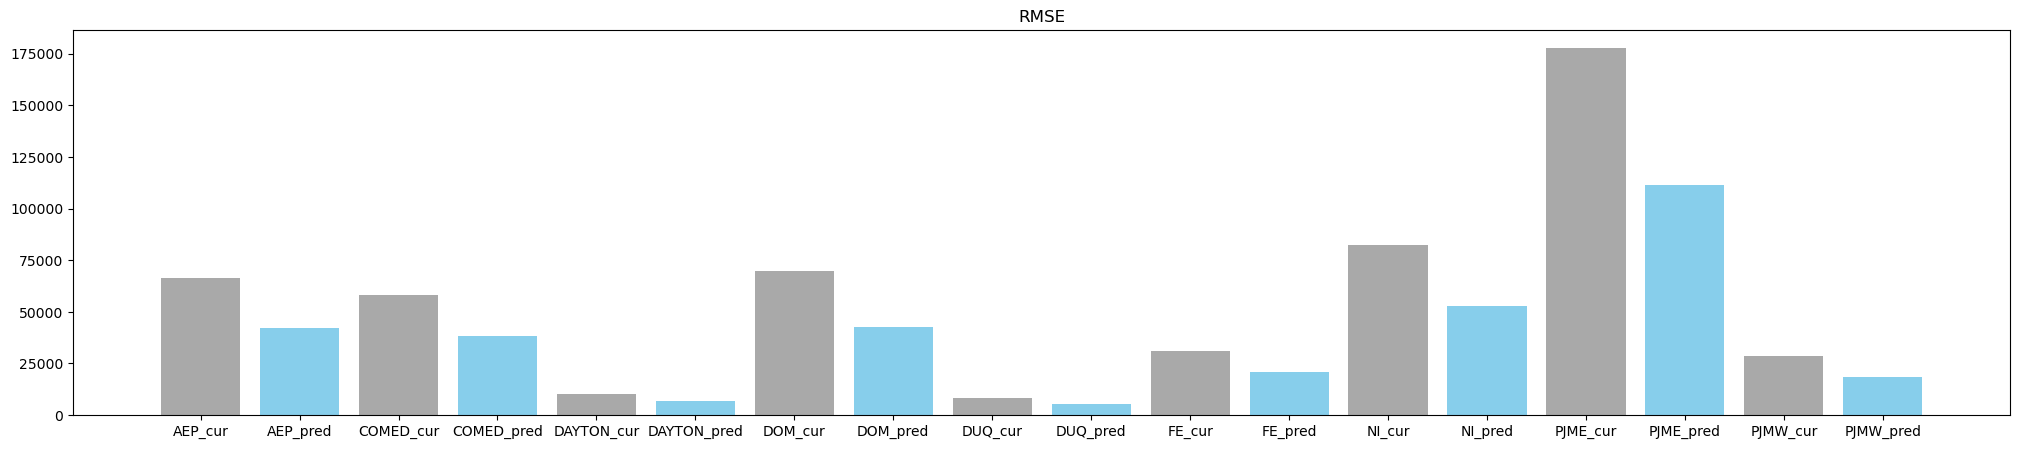

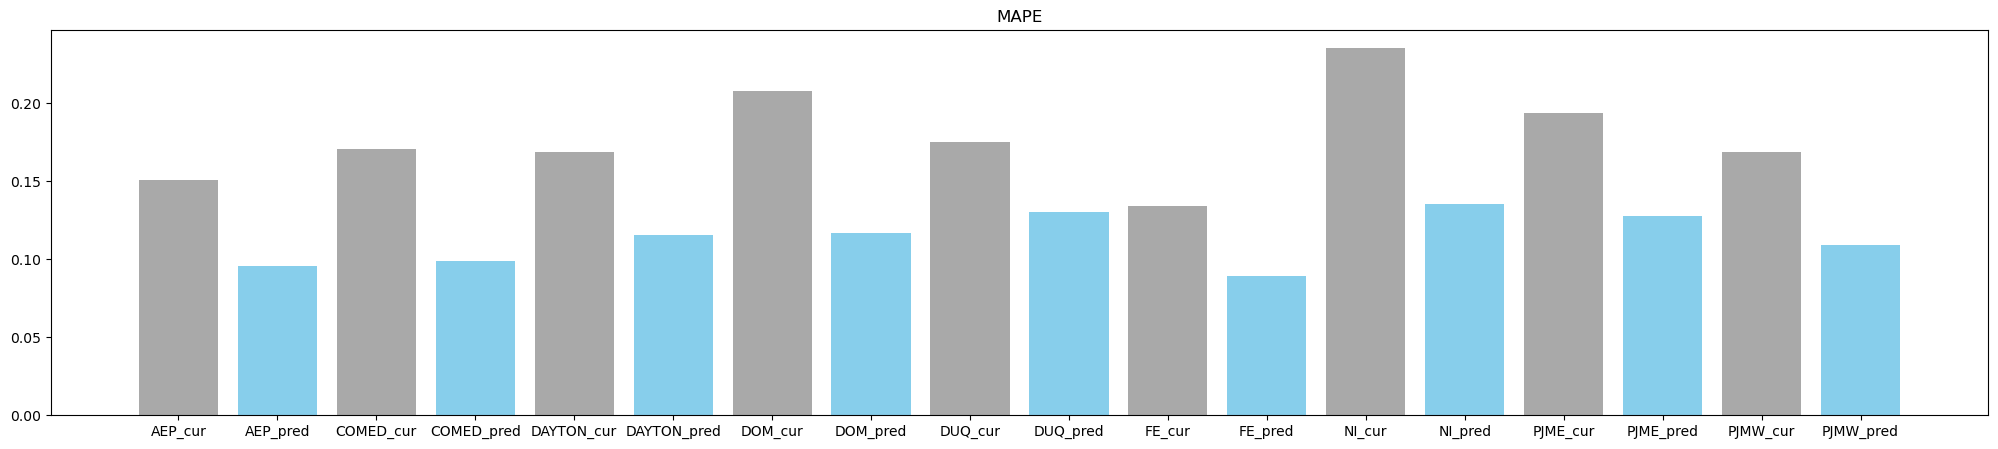

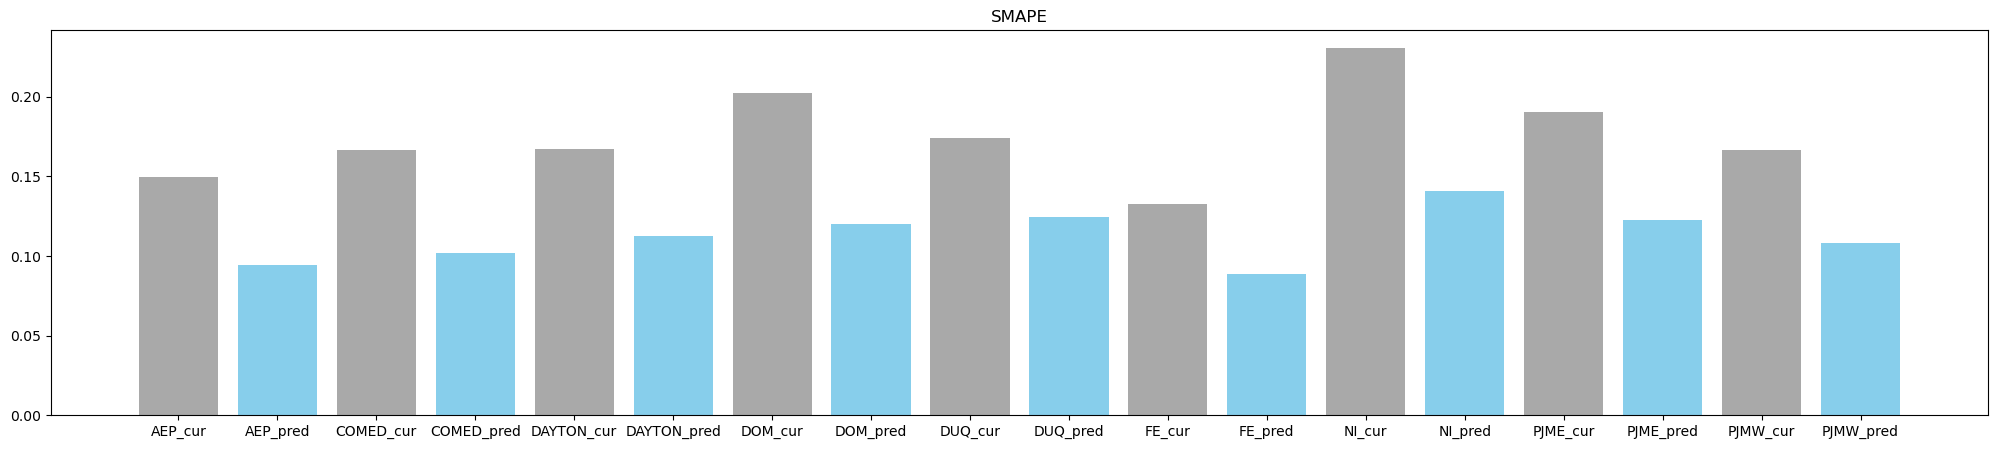

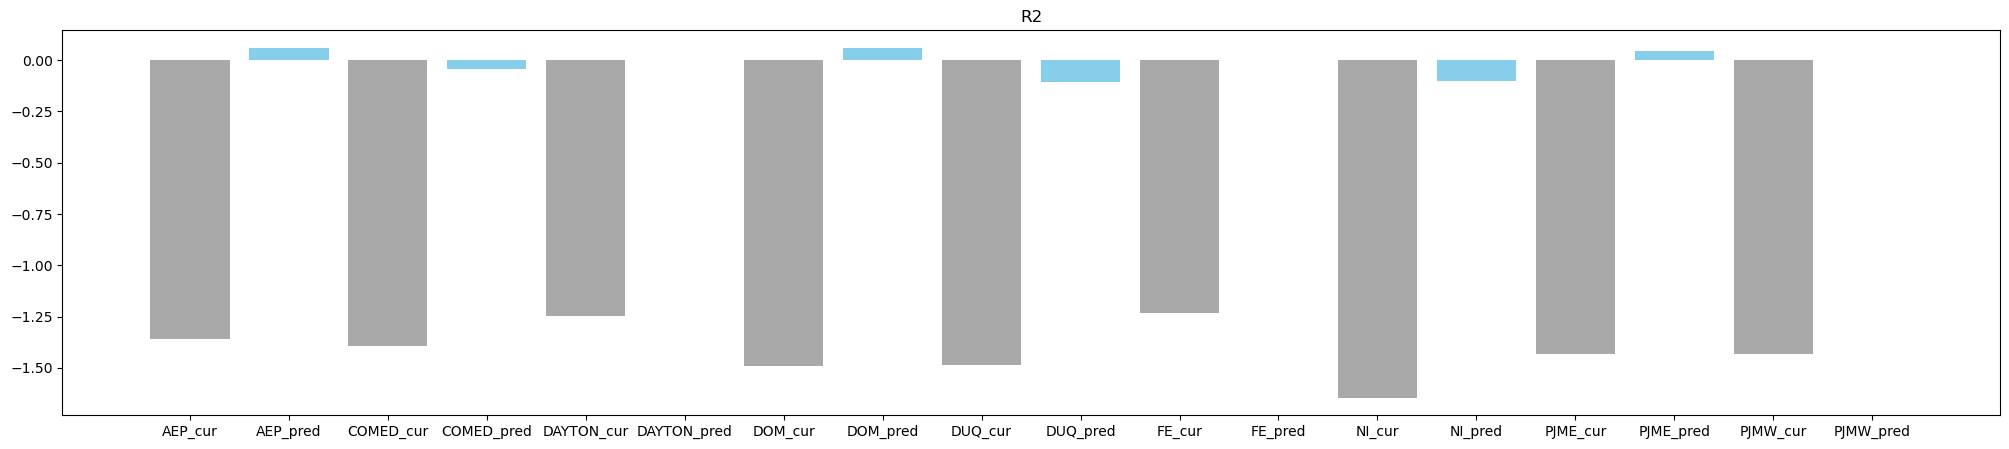

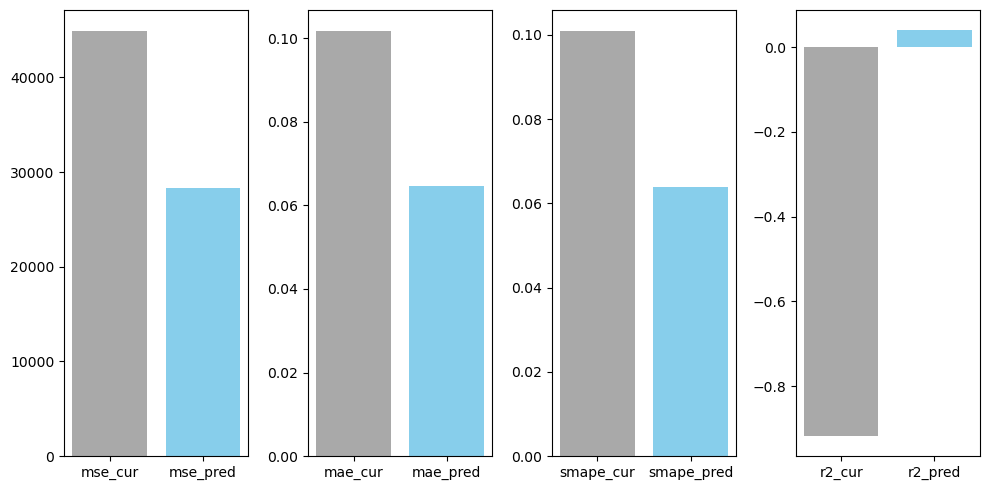

rmse : 44868.75390625 / 28329.931640625, mae : 0.10167006403207779 / 0.06457304954528809, smape : 0.10087133198976517 / 0.06381584703922272, r2_cur : -0.9175170063972473 / 0.040093131363391876


In [22]:
import torch.nn as nn
from torchmetrics.regression import SymmetricMeanAbsolutePercentageError as SMAPE, MeanAbsolutePercentageError as MAPE, R2Score as R2
# from torchmetrics import 

mse = nn.MSELoss()
mape = MAPE()
smape = SMAPE()
r2 = R2()

tot_len = 0

tot_mse_cur = 0
tot_mape_cur = 0
tot_smape_cur = 0
tot_r2_cur = 0

tot_mse_pred = 0
tot_mape_pred = 0
tot_smape_pred = 0
tot_r2_pred = 0

mse_score = []
mape_score = []
smape_score = []
r2_score = []

plot_col = 3

plt.figure(figsize=(10, 10))

for t in pmj_cols :
    if DATA_TYPE == 'PMJ_':
        cur, pred, true = torch.Tensor(cur_values['PMJ_' + t]), torch.Tensor(predictions['PMJ_' + t]), torch.Tensor(true_values['PMJ_' + t])
    else:
        cur, pred, true = torch.Tensor(cur_values[t]), torch.Tensor(predictions[t]), torch.Tensor(true_values[t])
    print(t, len(true))
    mse_score += [mse(cur, true) ** 0.5, mse(pred, true) ** 0.5]
    mape_score += [mape(cur, true), mape(pred, true)]
    smape_score += [smape(cur, true), smape(pred, true)]
    r2_score += [r2(cur, true), r2(pred, true)]
    print(f"rmse:{mse(cur, true)}, mape:{mape(cur, true)}, smape:{smape(cur, true)}, r2:{r2(cur, true)} (cur)")
    print(f"rmse:{mse(pred, true)}, mape:{mape(pred, true)}, smape:{smape(pred, true)}, r2:{r2(pred, true)} (pred)")

    tot_mse_cur += mse_score[0] * len(true)
    tot_mape_cur += mape_score[0] * len(true)
    tot_smape_cur += smape_score[0] * len(true)
    tot_r2_cur += r2_score[0] * len(true)

    tot_mse_pred += mse_score[1] * len(true)
    tot_mape_pred += mape_score[1] * len(true)
    tot_smape_pred += smape_score[1] * len(true)
    tot_r2_pred += r2_score[1] * len(true)
    
    tot_len =  len(true)


colors = ['darkgray', 'skyblue']

tot_mse_cur /= tot_len
tot_mape_cur /= tot_len
tot_smape_cur /= tot_len
tot_r2_cur /= tot_len

tot_mse_pred /= tot_len
tot_mape_pred /= tot_len
tot_smape_pred /= tot_len
tot_r2_pred /= tot_len


x_labels = []
for t in pmj_cols:
    x_labels += [t + '_cur', t + '_pred' ]

plt.figure(figsize=(25, 5))
plt.title('RMSE')
plt.bar(x_labels, mse_score, color=colors * 9)
plt.show()
plt.figure(figsize=(25, 5))
plt.title('MAPE')
plt.bar(x_labels, mape_score, color=colors * 9)
plt.show()
plt.figure(figsize=(25, 5))
plt.title('SMAPE')
plt.bar(x_labels, smape_score, color=colors * 9)
plt.show()
plt.figure(figsize=(25, 5))
plt.title('R2')
plt.bar(x_labels, r2_score, color=colors * 9)
plt.show()

tot_mse_cur /= len(pmj_cols)
tot_mape_cur /= len(pmj_cols)
tot_smape_cur /= len(pmj_cols)
tot_r2_cur /= len(pmj_cols)

tot_mse_pred /= len(pmj_cols)
tot_mape_pred /= len(pmj_cols)
tot_smape_pred /= len(pmj_cols)
tot_r2_pred /= len(pmj_cols)

plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.bar(['mse_cur', 'mse_pred'], [tot_mse_cur, tot_mse_pred, ], color=colors)
plt.subplot(1, 4, 2)
plt.bar(['mae_cur', 'mae_pred'], [tot_mape_cur, tot_mape_pred], color=colors)
plt.subplot(1, 4, 3)
plt.bar(['smape_cur', 'smape_pred'], [tot_smape_cur, tot_smape_pred], color=colors)
plt.subplot(1, 4, 4)
plt.bar(['r2_cur', 'r2_pred'], [tot_r2_cur, tot_r2_pred], color=colors)
plt.tight_layout()
plt.show()
print(f"rmse : {tot_mse_cur} / {tot_mse_pred}, mae : {tot_mape_cur} / {tot_mape_pred}, smape : {tot_smape_cur} / {tot_smape_pred}, r2_cur : {tot_r2_cur} / {tot_r2_pred}")

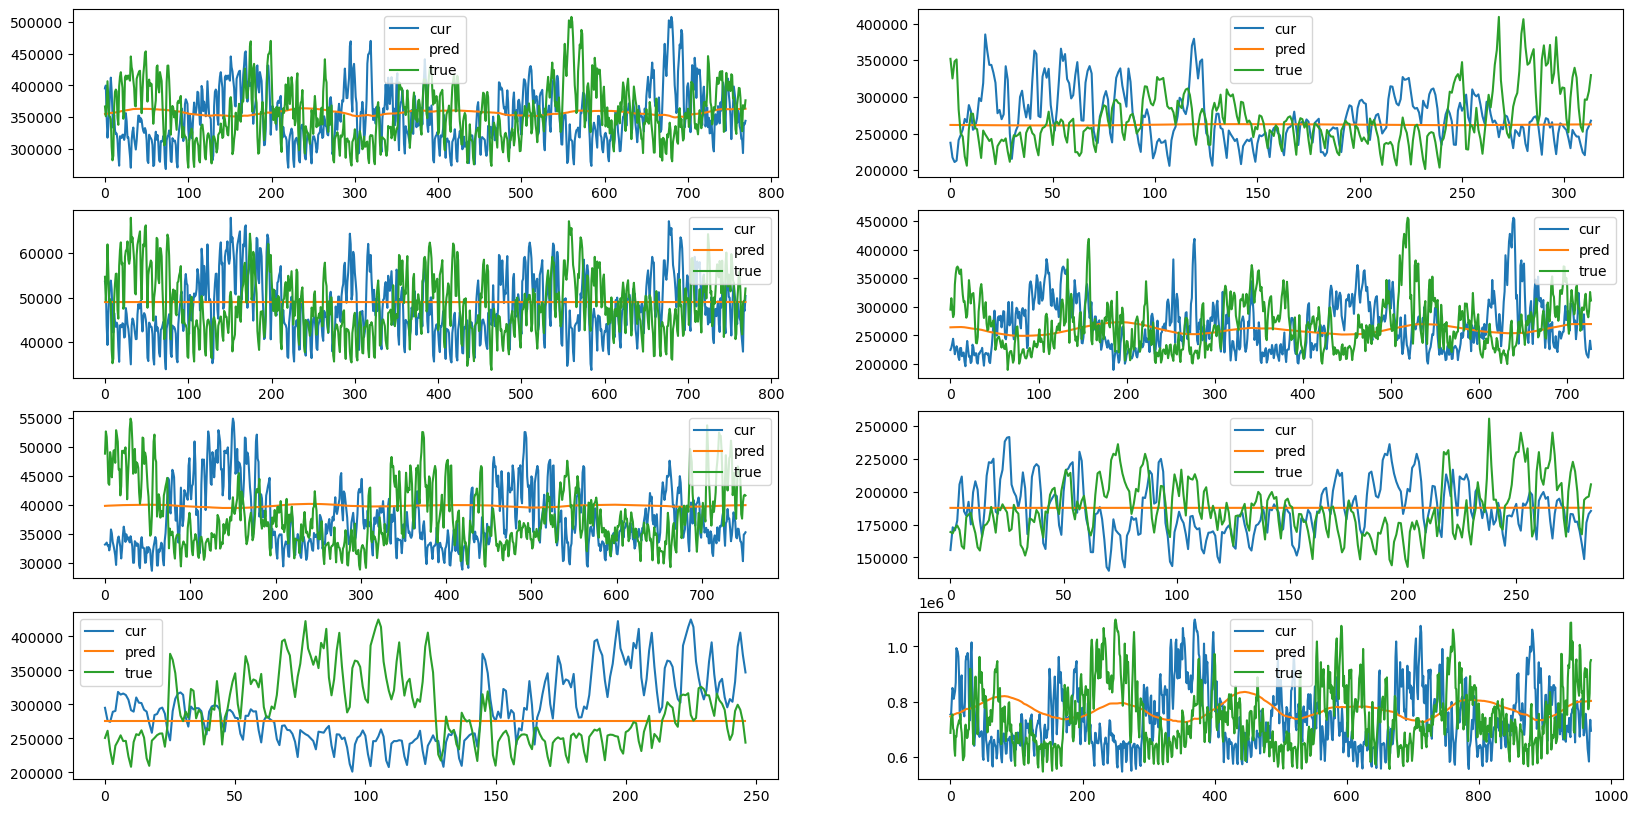

In [23]:
plot_col = 2
sub_num = [len(pmj_cols) // plot_col, plot_col, 1]
plt.figure(figsize=(20, 10))
for t in pmj_cols[:-1]:
    plt.subplot(*sub_num)
    if DATA_TYPE == 'PMJ_':
        plt.plot(cur_values['PMJ_' + t], label='cur')
        plt.plot(predictions['PMJ_' + t], label='pred')
        plt.plot(true_values['PMJ_' + t], label='true')
    else:
        plt.plot(cur_values[t], label='cur')
        plt.plot(predictions[t], label='pred')
        plt.plot(true_values[t], label='true')
    plt.legend()
    sub_num[-1] += 1
plt.show()